In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/To The Moon - From Reddit Comments to Stocks/Code/LSTMC"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/17-IViQXtJ7E70aIa03YJMvzoEf76guys/To The Moon - From Reddit Comments to Stocks/Code/LSTMC


In [ ]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [ ]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'num_comments', 'score', 'total_awards',
                          'author_commentkarma', 'compound_score', 'author_id', 'author_name',
                          'ticker', 'post_type', 'trustworthy', 'author_trust','adjclose_20_X',
                          'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
                          'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
                          'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
                          'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
                          'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
                          'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
                          'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                          'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
                          'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
                          'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'y_slope'])

# Create trend column
df['trend'] = df['y_slope'].apply(lambda x : 1 if x >= 0.5 else (-1 if x <= -0.5 else 0))

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

# Reset index
df.reset_index(drop=True, inplace=True)

df

,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,adjclose_17_X,adjclose_16_X,adjclose_15_X,adjclose_14_X,adjclose_13_X,adjclose_12_X,adjclose_11_X,adjclose_10_X,adjclose_9_X,adjclose_8_X,adjclose_7_X,adjclose_6_X,adjclose_5_X,adjclose_4_X,adjclose_3_X,adjclose_2_X,adjclose_1_X,adjclose_2_Y,adjclose_3_Y,adjclose_4_Y,adjclose_5_Y,adjclose_6_Y,adjclose_7_Y,adjclose_8_Y,adjclose_9_Y,adjclose_10_Y,adjclose_11_Y,adjclose_12_Y,adjclose_13_Y,adjclose_14_Y,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust,y_slope,trend
0,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271,1,0.888889,0.143927,0
1,ed2x6fn,2019-01-02,2,61,0.0,712.0,0.0516,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,25.551525,25.006222,24.753046,24.840681,24.791990,24.889368,24.791990,24.889368,24.714090,25.093859,25.171459,26.626459,27.101759,27.392757,27.218159,26.131760,26.092960,24.869894,25.415201,25.814445,26.184475,26.340277,26.447390,26.272114,25.678120,25.863132,25.639170,26.476604,26.340277,25.989721,26.301327,26.496077,26.213688,25.619692,25.366512,25.347040,25.551525,1,0.800000,0.000608,0
2,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,ABCB,comment,41.132088,40.978432,41.199310,40.594284,41.449005,40.805569,40.776756,40.776756,42.150063,42.764690,42.755089,41.842751,42.697472,42.630238,42.630238,42.908749,42.140461,41.919582,41.612270,41.957993,30.676592,31.871288,33.133419,33.056339,33.239395,33.123787,33.538078,33.239395,33.152691,34.048706,34.588245,34.915821,34.241390,34.154694,33.981266,35.175957,36.235764,36.524799,36.476631,36.563339,1,0.857143,0.245501,0
3,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,CFFN,comment,12.528222,12.340834,12.314064,11.957135,11.957135,11.921442,11.823287,11.796516,11.894671,11.689439,11.466356,11.118350,11.101046,11.031827,11.066439,11.144307,11.057785,11.031827,10.832822,10.789560,11.725131,12.028520,11.974982,12.215910,12.046366,12.108830,12.046366,11.903595,11.948212,12.019599,12.108830,12.171293,12.206985,12.251601,12.135600,12.233756,12.198063,11.983905,11.609129,11.559727,1,0.857143,-0.003275,0
4,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,FANG,comment,105.159828,106.703209,104.607254,104.645363,104.140427,99.919914,104.064209,103.587852,108.427612,108.903961,106.812767,103.453453,102.635025,104.899956,108.344917,105.299652,110.267235,107.888123,110.381439,108.792191,91.612320,95.204025,97.776329,99.986610,101.739594,101.110809,99.176819,99.567429,100.043777,100.643990,100.653511,101.834885,96.661659,96.537819,96.756943,97.376213,95.556526,95.423157,97.423836,98.243164,1,0.857143,-0.033058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36573,ghkrh6s,2020-12-31,1,18,0.0,1283.0,0.3612,ihqbc,keikun2002,WSBC,comment,28.073952,29.172199,29.535013,30.162582,28.730938,28.191620,28.436766,28.417154,28.495598,28.417154,26.897259,25.985319,26.485415,27.583662,26.887453,22.994558,23.543680,22.612131,24.749790,24.337948,29.590624,29.828459,32.186985,32.097797,31.433842,31.770777,32.107712,31.612219,32.186985,31.394205,31.354565,31.205917,30.700518,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000,-0.097593,0
36574,ghmxpxm,2020-12-31,0,10,0.0,1283.0,-0.1295,ihqbc,keikun20

In [ ]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'num_comments', 'score', 'total_awards',
       'author_commentkarma', 'compound_score', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'y_slope', 'trend'], dtype=object)

In [ ]:
"""Find when to buy and sell"""

# Columns of interest
tempDF = df[['adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
             'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
             'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
             'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 
             'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
             'adjclose_21_Y']]

# Divide each row by row minimum
df_buy = tempDF.div(tempDF.min(axis=1), axis=0)

# Divide each row by row maximum
df_sell = tempDF.div(tempDF.max(axis=1), axis=0)

# Empty list to store each row for buy
buy_rows = []

# Empty list to store each row for sell
sell_rows = []

# For each row
for i in range(len(tempDF.index)):
    
    """Buy"""
    # Convert the pandas row to a list
    buy_row = df_buy.iloc[i].tolist()
    
    # Filter the list for all elements starting from when the index where the value 1.0 is
    filt_row = buy_row[buy_row.index(1.0):]
    
    # If filter row contains a value >= 1.07
    if any(x >= 1.07 for x in filt_row):
        
        # All values not equal to 1 are assigned 0
        buy_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in buy_row]
    
    # Else, don't buy
    else:
        # Create row of all 0s
        buy_row = [0] * len(buy_row)
    
    # Append the row as data frame to buy_rows
    buy_rows.append(buy_row)
    
    """Sell"""
    # Convert the pandas row to a list
    sell_row = df_sell.iloc[i].tolist()
    
    # If the percent change from maximum to date of post is >= 7%
    if ((1-sell_row[0])/sell_row[0] >= 0.07):
        
        # All values not equal to 1 are assigned 0
        sell_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in sell_row]
    
    # else, don't sell
    else:
        # Create row of all 0s
        sell_row = [0] * len(sell_row)
    
    # Append the row as data frame to buy_rows
    sell_rows.append(sell_row)

# Column names for df_buy
cols = ['buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
        'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y', 
        'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y']

# Concatenate buy_rows into one data frame
df_buy = pd.DataFrame(buy_rows, columns=cols)

# Rename the columns
cols = ['sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y',
        'sell_7_Y', 'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y',
        'sell_13_Y', 'sell_14_Y', 'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y',
        'sell_19_Y', 'sell_20_Y', 'sell_21_Y']

# Concatenate buy_rows into one data frame
df_sell = pd.DataFrame(sell_rows, columns=cols)

# Display
display(df_buy.head())
display(df_sell.head())

# Concatenate df, df_buy, and df_sell
df = pd.concat([df, df_buy, df_sell], axis=1)

# Display
display(df.head())

# Count number of 0s in each buy column
for i in df_buy.columns:
    print("The number of 0s in", i, "is :", (df_buy[i] == 0).sum())

# Count number of 0s in each sell column
for i in df_sell.columns:
    print("The number of 0s in", i, "is :", (df_sell[i] == 0).sum())

,buy_1_X,buy_2_Y,buy_3_Y,buy_4_Y,buy_5_Y,buy_6_Y,buy_7_Y,buy_8_Y,buy_9_Y,buy_10_Y,buy_11_Y,buy_12_Y,buy_13_Y,buy_14_Y,buy_15_Y,buy_16_Y,buy_17_Y,buy_18_Y,buy_19_Y,buy_20_Y,buy_21_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,sell_1_X,sell_2_Y,sell_3_Y,sell_4_Y,sell_5_Y,sell_6_Y,sell_7_Y,sell_8_Y,sell_9_Y,sell_10_Y,sell_11_Y,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,adjclose_17_X,adjclose_16_X,adjclose_15_X,adjclose_14_X,adjclose_13_X,adjclose_12_X,adjclose_11_X,adjclose_10_X,adjclose_9_X,adjclose_8_X,adjclose_7_X,adjclose_6_X,adjclose_5_X,adjclose_4_X,adjclose_3_X,adjclose_2_X,adjclose_1_X,adjclose_2_Y,adjclose_3_Y,adjclose_4_Y,adjclose_5_Y,adjclose_6_Y,adjclose_7_Y,adjclose_8_Y,adjclose_9_Y,adjclose_10_Y,...,buy_3_Y,buy_4_Y,buy_5_Y,buy_6_Y,buy_7_Y,buy_8_Y,buy_9_Y,buy_10_Y,buy_11_Y,buy_12_Y,buy_13_Y,buy_14_Y,buy_15_Y,buy_16_Y,buy_17_Y,buy_18_Y,buy_19_Y,buy_20_Y,buy_21_Y,sell_1_X,sell_2_Y,sell_3_Y,sell_4_Y,sell_5_Y,sell_6_Y,sell_7_Y,sell_8_Y,sell_9_Y,sell_10_Y,sell_11_Y,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,comment,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ed2x6fn,2019-01-02,2,61,0.0,712.0,0.0516,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,25.551525,25.006222,24.753046,24.840681,24.791990,24.889368,24.791990,24.889368,24.714090,25.093859,25.171459,26.626459,27.101759,27.392757,27.218159,26.131760,26.092960,24.869894,25.415201,25.814445,26.184475,26.340277,26.447390,26.272114,25.678120,25.863132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,ABCB,comment,41.132088,40.978432,41.199310,40.594284,41.449005,40.805569,40.776756,40.776756,42.150063,42.764690,42.755089,41.842751,42.697472,42.630238,42.630238,42.908749,42.140461,41.919582,41.612270,41.957993,30.676592,31.871288,33.133419,33.056339,33.239395,33.123787,33.538078,33.239395,33.152691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,CFFN,comment,12.528222,12.340834,12.314064,11.957135,11.957135,11.921442,11.823287,11.796516,11.894671,11.689439,11.466356,11.118350,11.101046,11.031827,11.066439,11.144307,11.057785,11.031827,10.832822,10.789560,11.725131,12.028520,11.974982,12.215910,12.046366,12.108830,12.046366,11.903595,11.948212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,FANG,comment,105.159828,106.703209,104.607254,104.645363,104.140427,99.919914,104.064209,103.587852,108.427612,108.903961,106.812767,103.453453,102.635025,104.899956,108.344917,105.299652,110.267235,107.888123,110.381439,108.792191,91.612320,95.204025,97.776329,99.986610,101.739594,101.110809,99.176819,99.567429,100.043777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The number of 0s in buy_1_X is : 20260
The number of 0s in buy_2_Y is : 34312
The number of 0s in buy_3_Y is : 34847
The number of 0s in buy_4_Y is : 35402
The number of 0s in buy_5_Y is : 35431
The number of 0s in buy_6_Y is : 35388
The number of 0s in buy_7_Y is : 35823
The number of 0s in buy_8_Y is : 35557
The number of 0s in buy_9_Y is : 35871
The number of 0s in buy_10_Y is : 35787
The number of 0s in buy_11_Y is : 35997
The number of 0s in buy_12_Y is : 35990
The number of 0s in buy_13_Y is : 36091
The number of 0s in buy_14_Y is : 36040
The number of 0s in buy_15_Y is : 35918
The number of 0s in buy_16_Y is : 36073
The number of 0s in buy_17_Y is : 36090
The number of 0s in buy_18_Y is : 36092
The number of 0s in buy_19_Y is : 36312
The number of 0s in buy_20_Y is : 36221
The number of 0s in buy_21_Y is : 36536
The number of 0s in sell_1_X is : 36578
The number of 0s in sell_2_Y is : 34657
The number of 0s in sell_3_Y is : 35728
The number of 0s in sell_4_Y is : 35793
The numbe

In [ ]:
# Get the X-variable columns
df_X = df[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score', 'adjclose_20_X',
           'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
           'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
           'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
           'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
           'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X']]

# Get the Y-variable columns
df_Y = df[['trend','buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
           'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y',
           'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y',
           'sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y', 'sell_7_Y',
           'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y', 'sell_13_Y', 'sell_14_Y',
           'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y', 'sell_19_Y', 'sell_20_Y', 'sell_21_Y']]

# Clear up memory
del df
del tempDF
del cols
del df_buy
del df_sell
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       num_comments  score  ...  adjclose_2_X  adjclose_1_X
0                 9      6  ...     37.095379     36.598965
1                 2     61  ...     26.131760     26.092960
2                 0      2  ...     41.612270     41.957993
3                 0      2  ...     10.832822     10.789560
4                 0      2  ...    110.381439    108.792191
...             ...    ...  ...           ...           ...
29257             0      2  ...      1.140000      1.199998
29258             0      3  ...      3.090000      3.030000
29259             0      3  ...     11.770000     11.930000
29260             0      3  ...     30.790001     30.860001
29261             2      2  ...      2.480000      2.560000

[29262 rows x 25 columns]
       num_comments  score  ...  adjclose_2_X  adjclose_1_X
29262             0      1  ...     15.580000     14.250000
29263             1     36  ...     19.768454     19.219330
29264             1     16  ...     19.768454     19.219330
29265        

In [ ]:
print(X_train.shape)
print(X_test.shape)
red_train = X_train[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()

print(red_train.shape)


red_test = X_test[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']].to_numpy()
print(red_test.shape)

X_train = X_train.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_train.shape)

X_test = X_test.drop(columns = ['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score']).to_numpy()
print(X_test.shape)

(29262, 25)
(7316, 25)
(29262, 5)
(7316, 5)
(29262, 20)
(7316, 20)


In [ ]:
# Normalize data
scaler = MinMaxScaler()

n_features = 5

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(xtrain_scale.shape)

#xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], xtrain_scale.shape[1], n_features)
xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], 4, n_features)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)
#xval_scale = xval_scale.reshape(xval_scale.shape[0], xval_scale.shape[1], n_features)
xval_scale = xval_scale.reshape(xval_scale.shape[0], 4, n_features)

print(scaler.fit(red_train))
red_train_scale = scaler.transform(red_train)
print(scaler.fit(red_test))
red_test_scale = scaler.transform(red_test)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = xtrain_scale.shape[1]
outdim = ytrain_scale.shape[1]

#this dimension is for reddit data
input_dim = red_train_scale.shape[1]

# Predict
#ypred = model.predict(xval_scale)

# Scale back to original scale
#ypred = scaler.inverse_transform(ypred)

MinMaxScaler(copy=True, feature_range=(0, 1))
(29262, 20)
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

def create_mlp():
    model = Sequential()
    model.add(Dense(input_dim+1, input_dim=input_dim))
    # Hidden layer with ~sqrt(X_train.shape[0] = sqrt(188157))
    model.add(Dense(X_train.shape[0]**0.5, activation="relu"))
    return model

def create_lstm():
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=50, return_sequences=True, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False, input_shape=(indim, n_features)))
    model.add(Dropout(0.2))
    # Output layer
    #model.add(Dense(434))
    return model

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

mlp = create_mlp()
lstm = create_lstm()
combinedInput = Concatenate(axis=1)([mlp.output, lstm.output])
x = Dense(outdim)(combinedInput)
model = Model(inputs=[mlp.input, lstm.input], outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x=[red_train_scale, xtrain_scale], y=ytrain_scale, epochs=10, batch_size=128, verbose = 0)

ypred = model.predict([red_test_scale,xval_scale])

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

In [ ]:
# Evaluate Accuracy Score

# Convert y_test and ypred to type ints
y_test = y_test.to_numpy()
ypred = ypred.astype(int)

# Empty list to store accuracy scores
acc_score = []

# Empty list to store f1 scores
f1 = []

# For each column in ypred, calculate accuracy score
for i in range(ypred.shape[1]):
    
    acc_score.append(accuracy_score(y_test[:, i], ypred[:, i]))
    f1.append(f1_score(y_test[:, i], ypred[:, i], average='weighted', zero_division=0))

# For each value in accuracy
for j in range(len(acc_score)):

    if j == 0:
        print("The accuracy score for trend =", acc_score[j])
    elif j == 1:
        print("The accuracy score for buy_{}_X =".format(j), acc_score[j])
    elif 1 < j < 22:
        print("The accuracy score for buy_{}_Y =".format(j), acc_score[j])
    elif j == 22:
        print("The accuracy score for sell_{}_X =".format(j-21), acc_score[j])
    else:
        print("The accuracy score for sell_{}_Y =".format(j-21), acc_score[j])

print("\n")

# For each value in f1
for k in range(len(f1)):

    if k == 0:
        print("The f1 score for trend =", f1[k])
    elif k == 1:
        print("The f1 score for buy_{}_X =".format(k), f1[k])
    elif 1 < k < 22:
        print("The f1 score for buy_{}_Y =".format(k), f1[k])
    elif k == 22:
        print("The f1 score for sell_{}_X =".format(k-21), f1[k])
    else:
        print("The f1 score for sell_{}_Y =".format(k-21), f1[k])

# Print overall model average
print("\nThe overall accuracy score for buy is:", sum(acc_score[1:22])/len(acc_score[1:22]))
print("The overall f1 score for buy is:", sum(f1[1:22])/len(f1[1:22]))
print("The overall accuracy score for sell is:", sum(acc_score[22:])/len(acc_score[22:]))
print("The overall f1 score for sell is:", sum(f1[22:])/len(f1[22:]))

The accuracy score for trend = 0.8510114816839803
The accuracy score for buy_1_X = 0.2624384909786769
The accuracy score for buy_2_Y = 0.9499726626571897
The accuracy score for buy_3_Y = 0.9622744669218152
The accuracy score for buy_4_Y = 0.9774466921815199
The accuracy score for buy_5_Y = 0.9844177145981411
The accuracy score for buy_6_Y = 0.9844177145981411
The accuracy score for buy_7_Y = 0.9866047020229634
The accuracy score for buy_8_Y = 0.985784581738655
The accuracy score for buy_9_Y = 0.9900218698742482
The accuracy score for buy_10_Y = 0.9912520503007107
The accuracy score for buy_11_Y = 0.9935757244395844
The accuracy score for buy_12_Y = 0.9950792782941498
The accuracy score for buy_13_Y = 0.9905686167304538
The accuracy score for buy_14_Y = 0.9945325314379442
The accuracy score for buy_15_Y = 0.9915254237288136
The accuracy score for buy_16_Y = 0.9939857845817387
The accuracy score for buy_17_Y = 0.9949425915800985
The accuracy score for buy_18_Y = 0.9956260251503554
The ac

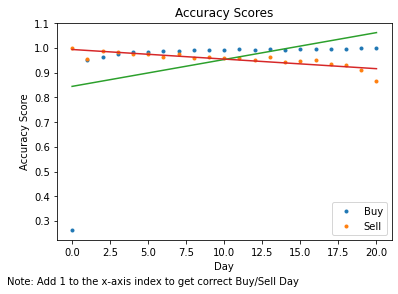

In [ ]:
# Plot the Accuracy Scores
x = np.arange(21)
y = acc_score[1:22]
y2 = acc_score[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('Accuracy Scores')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()

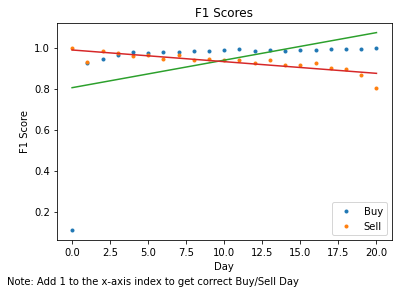

In [ ]:
# Plot the F1 Scores
x = np.arange(21)
y = f1[1:22]
y2 = f1[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('F1 Scores')
plt.xlabel('Day')
plt.ylabel('F1 Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()